In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point
import pyreadr
import mercantile
from shapely.geometry import shape
import networkx as nx
import seaborn as sn
import pickle
import scipy.sparse as sp
from scipy.optimize import least_squares
import datetime
import lmfit
from sklearn import metrics

from scipy.integrate import odeint

In [4]:
# root to store figures
root_figures = '/Users/ignaciosacristanbarba/Documents/M4R/Figures' 

# Try different models using odeind

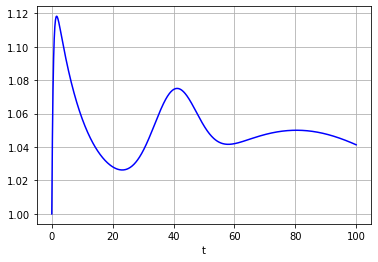

1.6


In [5]:
# define derivatives for different models

#with Gaussian stimulus, not good
def der(x,t,beta,alpha,lamb1,lamb2,lamb3,t1,t2,t3,m):
    dxdt = -beta*x + alpha*(np.exp(-lamb1*(t-t1))+np.exp(-lamb2*(t-t2)**2)+np.exp(-lamb3*(t-t3)**2)+m)+beta
    return dxdt

# single exponential
def der2(x,t,beta,alpha,lamb1,lamb2,m):
    dxdt = -beta*x + alpha*(np.exp(-lamb1*(t))+m)+beta
    return dxdt


x0 = 1
beta = 2
alpha = 0.1
lamb1 = 0.1
lamb2 = 0.01
lamb3 = 0.0005
t1 = 10
t2 = 40
t3 = 80
m = 0
t = np.linspace(0, 100, 1001)
sol = odeint(der, x0, t, args=(beta, alpha,lamb1,lamb2,lamb3,t1,t2,t3,m))


#plot shapes 

plt.plot(t, sol, 'b')
plt.xlabel('t')
plt.grid()
plt.show()
print(t[np.argmax(sol)])

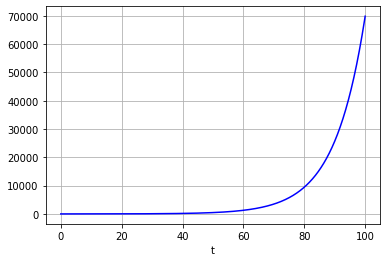

max at t = 27.0


In [6]:
# try others 

# two exponentials centered at different times, but no smooth transition
def der4(x,t,beta,alpha,lamb1,lamb2,t1,m):
    dxdt = -beta*x + alpha*(np.exp(-lamb1*(t-t1))+np.exp(-lamb2*(t-50)**2)+m)+beta
    return dxdt


# two exponentials centered at different times, but no smooth transition, t2 allowed to vary
def der5(x,t,beta,alpha,lamb1,lamb2,t1,t2,m):
    dxdt = -beta*x +alpha*(np.exp(-lamb1*(t-t1))+np.exp(-lamb2*(t-t2))+m)+beta
    return dxdt

# two exponentials centered at different times, but no smooth transition
def der6(x,t,beta,alpha,lamb1,lamb2,t1,t2,m):
    dxdt = -beta*x +alpha*(np.exp(-lamb1*abs(t-t1))+np.exp(-lamb2*abs(t-t2))+m)+beta
    return dxdt

#splitting derivative vector, does not work
def der7(x,t,beta,alpha,lamb_b,lamb_a,t1,m):
    dxdt = np.zeros(len(x))
    dxdt[:t1] = -beta*x +alpha*(np.exp(lamb_b*(t-t1))+m)+beta
    dxdt[t1:] = -beta*x +alpha*(np.exp(-lamb_a*(t-t1))+m)+beta
    return dxdt



beta = 0.016

alpha = 1

lamb1 =0.1
lamb2 =0.5

t1 =10
t2 =80
m =0 


t = np.linspace(0, 100, 1001)
sol = odeint(der6, x0, t, args=(beta,alpha,lamb1,lamb2,t1,t2,m))

sol7 = odeint(der7, x0, t, args=(beta,alpha,lamb1,lamb2,t1,m))

plt.plot(t, sol7, 'b')
plt.xlabel('t')
plt.grid()
plt.show()
print('max at t =',t[np.argmax(sol)])

# Define analytical solution instead 

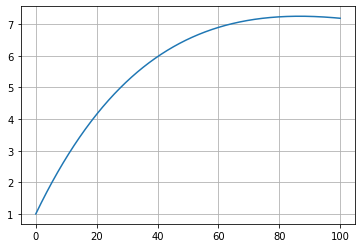

max at t = 86.60000000000001


In [7]:
#for single exponential stimulus
def response(x,alpha,beta,lamb1,t1,m):
    y = 1 + (alpha/(beta-lamb1)*np.exp(-lamb1*t1)*(np.exp(-lamb1*x)-np.exp(-beta*x))+
            alpha*m/beta*(1-np.exp(-beta*x)))
    return y

t = np.linspace(0, 100, 1001)
beta = 0.016
alpha = 0.2
lamb1 =0.008
t1 = 0
m =0
res = response(t,alpha,beta,lamb1,t1,m)

plt.plot(t,res)
plt.grid()
plt.show()
print('max at t =',t[np.argmax(res)])

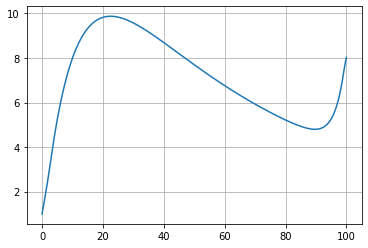

In [8]:
# for two exponentials, symmetric
def fun1(x, alpha,beta,lamb1,lamb2,t1,t2, m):
    y = np.zeros(len(x))
    
    t1 = t1*x[-1]/100

    t2 = t2*x[-1]/100

    for i,s in enumerate(x):
        if s <= t1:
             y[i] = (1+m*alpha/beta*(1-np.exp(-beta*s))+alpha/(beta+lamb1)*(np.exp(lamb1*(s-t1))-np.exp(-beta*s-lamb1*t1)))
        else:
             y[i] =(1+m*alpha/beta*(1-np.exp(-beta*s))+
                     alpha/(beta+lamb1)*(np.exp(-beta*(s-t1))-np.exp(-beta*s-lamb1*t1))+
                     alpha/(beta-lamb1)*(np.exp(-lamb1*(s-t1))-np.exp(-beta*(s-t1))))
        if s<=t2:
            y[i] += (alpha/(beta+lamb2)*(np.exp(lamb2*(s-t2))-np.exp(-beta*s-lamb2*t2)))
        else:
            y[i] +=(alpha/(beta+lamb2)*(np.exp(-beta*(s-t2))-np.exp(-beta*s-lamb2*t2))+
                     alpha/(beta-lamb2)*(np.exp(-lamb2*(s-t2))-np.exp(-beta*(s-t2))))
    return np.nan_to_num(y)



x = np.linspace(0, 100, 1000)

beta = 0.016

alpha = 1

lamb1 =0.1
lamb2 =0.3

t1 =3
t2 =99
m =0 

y = fun1(x, alpha, beta,lamb1,lamb2,t1,t2, m)

plt.plot(x,y)
plt.grid()

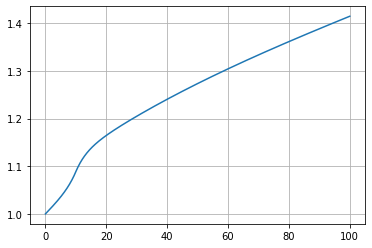

In [9]:
# For asymmetric Laplacian
def fun_asymetric(x, alpha,beta,lamb1a,lamb1b,lamb2a,lamb2b,t1,t2, m):
    y = np.zeros(len(x))
    
    t1 = t1*x[-1]/100

    t2 = t2*x[-1]/100

    for i,s in enumerate(x):
        if s <= t1:
             y[i] = (1+m*alpha/beta*(1-np.exp(-beta*s))+alpha/(beta+lamb1a)*(np.exp(lamb1a*(s-t1))-np.exp(-beta*s-lamb1a*t1)))
        else:
             y[i] =(1+m*alpha/beta*(1-np.exp(-beta*s))+
                     alpha/(beta+lamb1a)*(np.exp(-beta*(s-t1))-np.exp(-beta*s-lamb1a*t1))+
                     alpha/(beta-lamb1b)*(np.exp(-lamb1b*(s-t1))-np.exp(-beta*(s-t1))))
        if s<=t2:
            y[i] += (alpha/(beta+lamb2a)*(np.exp(lamb2a*(s-t2))-np.exp(-beta*s-lamb2a*t2)))
        else:
            y[i] +=(alpha/(beta+lamb2a)*(np.exp(-beta*(s-t2))-np.exp(-beta*s-lamb2a*t2))+
                     alpha/(beta-lamb2b)*(np.exp(-lamb2b*(s-t2))-np.exp(-beta*(s-t2))))
    return np.nan_to_num(y)

# set parameters and plot
x = np.linspace(0, 100, 1000)
beta = 0.016
alpha = 0.01
lamb1a =0.3
lamb1b = 0.3
lamb2a =0.004
lamb2b = 0.2
t1 =10
t2 =120
m =0 

y = fun_asymetric(x, alpha, beta,lamb1a,lamb1b,lamb2a,lamb2b,t1,t2, m)

plt.plot(x,y)
plt.grid()

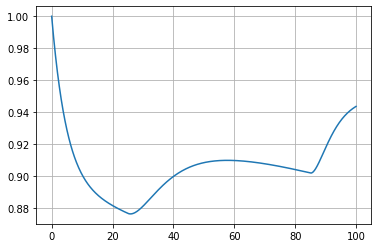

In [10]:
#for asymmetric Laplacian, another try
def try9(x, alpha,beta,lamb1a,lamb1b,lamb2a,lamb2b,t1,t2, m):
    y = np.zeros(len(x))
    
    t1 = t1*x[-1]/100

    t2 = t2*x[-1]/100

    for i,s in enumerate(x):
        if s <= t1:
             y[i] = (1+m*alpha/beta*(1-np.exp(-beta*s))+alpha/(beta+lamb1a)*(np.exp(lamb1a*(s-t1))-np.exp(-beta*s-lamb1a*t1)))
        else:
             y[i] =(1+m*alpha/beta*(1-np.exp(-beta*s))+
                     alpha/(beta+lamb1a)*(np.exp(-beta*(s-t1))-np.exp(-beta*s-lamb1a*t1))+
                     alpha/(beta-lamb1b)*(np.exp(-lamb1b*(s-t1))-np.exp(-beta*(s-t1))))
        if s<=t2:
            y[i] += (alpha/(beta+lamb2a)*(np.exp(lamb2a*(s-t2))-np.exp(-beta*s-lamb2a*t2)))
        else:
            y[i] +=(alpha/(beta+lamb2a)*(np.exp(-beta*(s-t2))-np.exp(-beta*s-lamb2a*t2))+
                     alpha/(beta-lamb2b)*(np.exp(-lamb2b*(s-t2))-np.exp(-beta*(s-t2))))
    return np.nan_to_num(y)


x = np.linspace(0, 100, 800)

beta = 0.2

alpha = -0.01

lamb1a =0.01
lamb1b = 0.1
lamb2a =0.01
lamb2b = 0.3

t1 =25
t2 =85
m =1

y = try9(x, alpha, beta,lamb1a,lamb1b,lamb2a,lamb2b,t1,t2, m)

plt.plot(x,y)
plt.grid()

# Final plots 

## Asymmetric Laplacian

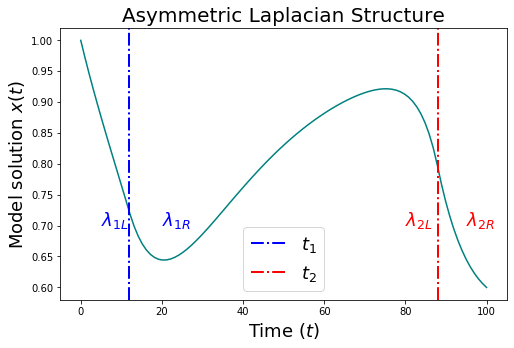

In [11]:
def response_asymetric_laplacian(x, alpha,beta,lamb1a,lamb1b,lamb2a,lamb2b,t1,t2, m):
    y = np.zeros(len(x))
    
    t1 = t1*x[-1]/100

    t2 = t2*x[-1]/100

    for i,s in enumerate(x):
        if s <= t1:
             y[i] = (1+m*alpha/beta*(1-np.exp(-beta*s))+alpha/(beta+lamb1a)*(np.exp(lamb1a*(s-t1))-np.exp(-beta*s-lamb1a*t1)))
        else:
             y[i] =(1+m*alpha/beta*(1-np.exp(-beta*s))+
                     alpha/(beta+lamb1a)*(np.exp(-beta*(s-t1))-np.exp(-beta*s-lamb1a*t1))+
                     alpha/(beta-lamb1b)*(np.exp(-lamb1b*(s-t1))-np.exp(-beta*(s-t1))))
        if s<=t2:
            y[i] += (alpha/(beta+lamb2a)*(np.exp(lamb2a*(s-t2))-np.exp(-beta*s-lamb2a*t2)))
        else:
            y[i] +=(alpha/(beta+lamb2a)*(np.exp(-beta*(s-t2))-np.exp(-beta*s-lamb2a*t2))+
                     alpha/(beta-lamb2b)*(np.exp(-lamb2b*(s-t2))-np.exp(-beta*(s-t2))))
    return np.nan_to_num(y)

alpha = -0.05
beta = 0.1

lamb1a=0.05
lamb1b =0.04

lamb2a=0.2
lamb2b=0.01

t1=12
t2=88
m=0

x = np.linspace(0, 100, 100)
y = response_asymetric_laplacian(x, alpha, beta,lamb1a,lamb1b,lamb2a,lamb2b,t1,t2, m)

fig,ax = plt.subplots(1,figsize=(8,5))


ax.plot(x,y,'-',color = 'teal',)
ax.axvline(x = t1,linestyle='-.', color = 'blue',label = r'$t_1$',linewidth=2)
ax.axvline(x = t2,linestyle='-.', color = 'red',label = r'$t_2$',linewidth=2)

ax.set_xlabel('Time ($t)$',fontsize = 18)
ax.set_ylabel(r'Model solution $x(t)$',fontsize = 18)
ax.set_title(r'Asymmetric Laplacian Structure',fontsize = 20)


ax.annotate(r'$\lambda_{1L}$',(5,0.7),size = 18,color = 'blue')
ax.annotate(r'$\lambda_{1R}$',(20,0.70),size = 18,color = 'blue')
ax.annotate(r'$\lambda_{2L}$',(80,0.7),size = 18,color = 'red')
ax.annotate(r'$\lambda_{2R}$',(95,0.7),size = 18,color = 'red')

ax.legend(fontsize = 18)

fig.savefig(root_figures + '/asymmetric_laplacian.pdf')


## Symmetric Laplacian

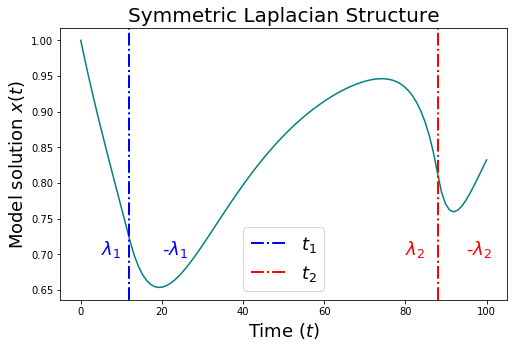

In [12]:
def response_laplacian(x, alpha,beta,lamb1,lamb2,t1,t2, m):
    y = np.zeros(len(x))
    t1 = t1*x[-1]/100
    t2 = t2*x[-1]/100
    
    for i,s in enumerate(x):
        if s <= t1:
             y[i] = (1+m*alpha/beta*(1-np.exp(-beta*s))+alpha/(beta+lamb1)*(np.exp(lamb1*(s-t1))-np.exp(-beta*s-lamb1*t1)))
        else:
             y[i] =(1+m*alpha/beta*(1-np.exp(-beta*s))+
                     alpha/(beta+lamb1)*(np.exp(-beta*(s-t1))-np.exp(-beta*s-lamb1*t1))+
                     alpha/(beta-lamb1)*(np.exp(-lamb1*(s-t1))-np.exp(-beta*(s-t1))))
        if s<=t2:
            y[i] += (alpha/(beta+lamb2)*(np.exp(lamb2*(s-t2))-np.exp(-beta*s-lamb2*t2)))
        else:
            y[i] +=(alpha/(beta+lamb2)*(np.exp(-beta*(s-t2))-np.exp(-beta*s-lamb2*t2))+
                     alpha/(beta-lamb2)*(np.exp(-lamb2*(s-t2))-np.exp(-beta*(s-t2))))
    return np.nan_to_num(y)


alpha = -0.05
beta = 0.1

lamb1=0.05

lamb2=0.2

t1=12
t2=88
m=0

x = np.linspace(0, 100, 100)
y = response_laplacian(x, alpha, beta,lamb1,lamb2,t1,t2, m)

fig,ax = plt.subplots(1,figsize=(8,5))


ax.plot(x,y,'-',color = 'teal',)
ax.axvline(x = t1,linestyle='-.', color = 'blue',label = r'$t_1$',linewidth=2)
ax.axvline(x = t2,linestyle='-.', color = 'red',label = r'$t_2$',linewidth=2)

ax.set_xlabel('Time ($t)$',fontsize = 18)
ax.set_ylabel(r'Model solution $x(t)$',fontsize = 18)
ax.set_title(r'Symmetric Laplacian Structure',fontsize = 20)


ax.annotate(r'$\lambda_{1}$',(5,0.7),size = 18,color = 'blue')
ax.annotate(r'-$\lambda_{1}$',(20,0.70),size = 18,color = 'blue')
ax.annotate(r'$\lambda_{2}$',(80,0.7),size = 18,color = 'red')
ax.annotate(r'-$\lambda_{2}$',(95,0.7),size = 18,color = 'red')

ax.legend(fontsize = 18)
fig.savefig(root_figures + '/symmetric_laplacian.pdf')
